## 1. Introduction to Reflection

In [1]:
import json
import os

with open('vars.json') as f:
    data = json.load(f)

openai_api_key = data["open_ai_api_key"]
langchain_api_key = data["langchain_api_key"]
# tavily_api_key = data["tavily_api_key"]
groq_api_key = data["groq_api_key"]

iterations = 2

# os.environ['LANGCHAIN_TRACING_V2'] = 'true'
# os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
# os.environ['LANGCHAIN_API_KEY'] = langchain_api_key

In [2]:
# Setting up DB connection 
from langchain_community.utilities import SQLDatabase

# Docker command to run pgvector/postgres container
# docker run --name pgvector-container -e POSTGRES_USER=langchain -e POSTGRES_PASSWORD=langchain -e POSTGRES_DB=langchain -p 6024:5432 -d pgvector/pgvector:pg16
db_config = {
    'dbname': 'postgres',
    'user': 'langchain',
    'password': 'langchain',
    'host': 'localhost',
    'port': '6024'
}

connection_string = f"postgresql+psycopg://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['dbname']}"

db = SQLDatabase.from_uri(connection_string)
print(db.table_info)


CREATE TABLE customer (
	customer_id SERIAL NOT NULL, 
	name VARCHAR(100) NOT NULL, 
	CONSTRAINT customer_pkey PRIMARY KEY (customer_id)
)

/*
3 rows from customer table:
customer_id	name
1	John Doe
2	Jane Smith
3	Alice Johnson
*/


CREATE TABLE feedback (
	feedback_id SERIAL NOT NULL, 
	order_id INTEGER NOT NULL, 
	feedback_text TEXT, 
	CONSTRAINT feedback_pkey PRIMARY KEY (feedback_id), 
	CONSTRAINT feedback_order_id_fkey FOREIGN KEY(order_id) REFERENCES orders (order_id)
)

/*
3 rows from feedback table:
feedback_id	order_id	feedback_text
4	4	Pizza was average.
5	5	Pizza was average.
6	6	Pizza was average.
*/


CREATE TABLE orders (
	order_id SERIAL NOT NULL, 
	customer_id INTEGER NOT NULL, 
	preparation_time INTEGER NOT NULL, 
	order_date TIMESTAMP WITHOUT TIME ZONE DEFAULT CURRENT_TIMESTAMP, 
	CONSTRAINT orders_pkey PRIMARY KEY (order_id), 
	CONSTRAINT orders_customer_id_fkey FOREIGN KEY(customer_id) REFERENCES customer (customer_id)
)

/*
3 rows from orders table:
order_id	custo

In [3]:
from langchain_agents._models import get_llm

llm_llama3 = get_llm(llm_type='llama3', llm_model='llama3-70b-8192', api_key=groq_api_key)

In [4]:
# Step 1 :- Retrieve from SQL 
from langchain_core.prompts import ChatPromptTemplate

from langchain_agents._tools import create_df_from_sql, python_shell
from langchain_agents._schemas import AgentState, RawToolMessage

retrieve_from_db_prompt_string = f"""\
You are an expert at PostgreSQL. You have access to a PostgreSQL database \
with the following tables

{db.table_info}

Given a user question related to the data in the database, \
first get the relevant data from the tables as a DataFrame using the create_df_from_sql tool. \
If the user provides critique, respond with a revised version of your previous attempts."""

retrieve_from_db_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", retrieve_from_db_prompt_string),
        ("placeholder", "{messages}"),
    ]
)

In [5]:
from langchain_core.prompts import MessagesPlaceholder

sql_reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a Data Engineer reviewing an sql query which will be executed in a PostgreSQL database. "
            "Following will be provided for you. "
            "{QUESTION}: the question asked regarding the data in the database. "
            "{QUERY}: the SQL query that will be executed in the database to answer the above question. "
            "Generate critique and recommendations for the user's query submission. "
            "Provide detailed recommendations, including additional information that will be helpful while generating reports."
            f"The tables in the database are as follows: {db.table_info}."
        )
    ]
)
sql_reflect = sql_reflection_prompt | llm_llama3

In [6]:
sql_reflect.invoke(
    {"QUESTION": "Graph the total number of orders of each customer. X axis of the graph has to be in ascending order.",
     "QUERY": "SELECT c.name, COUNT(o.order_id) AS total_orders FROM customer c JOIN orders o ON c.customer_id = o.customer_id GROUP BY c.name ORDER BY total_orders ASC;"
     }
)

AIMessage(content="**Critique and Recommendations**\n\nThe provided SQL query is:\n```sql\nSELECT c.name, COUNT(o.order_id) AS total_orders\nFROM customer c\nJOIN orders o ON c.customer_id = o.customer_id\nGROUP BY c.name\nORDER BY total_orders ASC;\n```\n**Good practices:**\n\n1. The query uses a meaningful alias `total_orders` for the count of orders, making it easier to understand the result set.\n2. The `JOIN` clause is correctly used to link the `customer` and `orders` tables based on the `customer_id` column.\n\n**Improvement suggestions:**\n\n1. **Consider adding a filter**: The query will return all customers, even if they have no orders. If you only want to show customers with at least one order, add a `HAVING` clause: `HAVING COUNT(o.order_id) > 0`.\n2. **Use table aliases consistently**: The query uses `c` as an alias for the `customer` table, but not for the `orders` table. For consistency, consider using `o` as an alias for the `orders` table throughout the query.\n3. **Co

In [7]:
from typing import List, Sequence

from langgraph.graph import END, StateGraph, START
from langchain_core.messages import HumanMessage, AIMessage


def retrieve_from_db_model_llama3(state: AgentState) -> dict:
    """Call model with tools passed in."""
    messages = []

    print("-----------------retrieve_from_db-----------------")
    chain = retrieve_from_db_prompt | llm_llama3.bind_tools([create_df_from_sql])
    retrieve_response = chain.invoke({"messages": [state["messages"][-1]]})
    input_question = state["messages"][0][1]
    message = {
        "retrieve_response": retrieve_response,
        "input_question": input_question
    }
    print(f"input_question :- {input_question}")
    print(f"output_query :- {retrieve_response.tool_calls[0]['args']['select_query']}")
    messages.append(message)
    print("--------------------------------------------------")

    return {"messages": messages}


def sql_reflection_node(state: AgentState) -> dict:
    print("-----------------sql_reflection_node-----------------")
    # First message is the original user request. We hold it the same for all nodes
    llm_input = {
        "QUESTION": state["messages"][-1]['input_question'],
        "QUERY": state["messages"][-1]['retrieve_response'].tool_calls[0]['args']['select_query']
    }
    res = sql_reflect.invoke(llm_input)
    print(f"""reflection :- \n{res.content}""")
    # We treat the output of this as human feedback for the generator
    print("--------------------------------------------------")
    return {"messages": [res]}


builder = StateGraph(AgentState)
builder.add_node("retrieve_from_db", retrieve_from_db_model_llama3)
builder.add_node("sql_reflection", sql_reflection_node)
builder.add_edge(START, "retrieve_from_db")


def should_continue(state: AgentState):
    if len(state["messages"]) > iterations * 2:
        return END
    return "sql_reflection"


builder.add_conditional_edges("retrieve_from_db", should_continue)
builder.add_edge("sql_reflection", "retrieve_from_db")
graph = builder.compile()

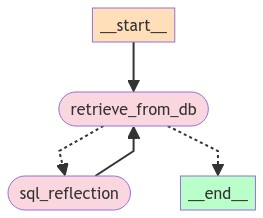

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
output_llama3 = graph.invoke({"messages": [
    ("human", "Graph the total number of orders of each customer. X axis of the graph has to be in ascending order.")]})

-----------------retrieve_from_db-----------------
input_question :- Graph the total number of orders of each customer. X axis of the graph has to be in ascending order.
output_query :- SELECT customer_id, COUNT(*) AS count FROM orders GROUP BY customer_id ORDER BY customer_id ASC
--------------------------------------------------
-----------------sql_reflection_node-----------------
reflection :- 
**Query Critique and Recommendations**

The provided SQL query is:
```sql
SELECT customer_id, COUNT(*) AS count
FROM orders
GROUP BY customer_id
ORDER BY customer_id ASC;
```
**Good:**

* The query is simple and easy to understand.
* It correctly groups the orders by customer_id and counts the number of orders for each customer.
* The ORDER BY clause ensures that the results are sorted in ascending order by customer_id.

**Suggestions for Improvement:**

1. **Consider adding a filter for active customers**: If you only want to include customers who have placed at least one order, you can add

## 2. Adding Reflection to Our Custom LangGraph Agent

In [10]:
# Step 2 :- Deciding future step according to the question 
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_agents._structured_outputs import IsSemantic

is_semantic_prompt_string = f"""
You are a Data Analyst. You will be given a QUESTION.
You have to decide whether the question is releated to customer feedbacks.
"""

is_semantic_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", is_semantic_prompt_string),
        ("human", "QUESTION: {question}"),
    ]
)


def decide_is_semantic_llama3(state: AgentState) -> dict:
    """Call model to decide weather the question is related to customer feedbacks"""
    messages = []

    chain = is_semantic_prompt | llm_llama3.with_structured_output(IsSemantic)
    question = state["messages"][-1]['input_question']
    print(f"question :- {question}")
    messages.append(chain.invoke({"question": question}))
    print(f"is_semantic_model_llama3 :- {messages}")
    print("-------------------------------------------------------")

    return {"messages": messages}


def is_semantic(state: AgentState) -> str:
    return "analyze_feedbacks" if state["messages"][-1].binary_score == 1 else "generate_python_script"


# Branch 1. Step 1 :- Generating python code to answer the question
from langchain_agents._structured_outputs import PythonScript

generate_python_script_prompt_string = f"""
You are a Python expert. 
You will be given a QUESTION, pandas dataframe name as DATAFRAME_NAME, column names of the dataframe as COLUMN_NAMES 
and the sql select QUERY used to get the dataframe. 
Using QUESTION, pandas DATAFRAME_NAME, COLUMN_NAMES of the dataframe and sql QUERY used to get the dataframe as reference 
Give a Python code to answer the QUESTION. Make sure to print any important results.
"""

generate_python_script_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", generate_python_script_prompt_string),
        ("human",
         "QUESTION: {question}, DATAFRAME_NAME: {dataframe_name}, COLUMN_NAMES: {column_names}, QUERY: {query}"),
    ]
)


def generate_python_script_llama3(state: AgentState) -> dict:
    messages = []

    chain = generate_python_script_prompt | llm_llama3.with_structured_output(PythonScript)

    question = state["messages"][-2]['input_question']
    dataframe_name = state["messages"][-2]['retrieve_response'].tool_calls[0]['args']['df_name']
    column_names = state["messages"][-2]['retrieve_response'].tool_calls[0]['args']['df_columns']
    query = state["messages"][-2]['retrieve_response'].tool_calls[0]['args']['select_query']

    messages.append(chain.invoke({
        "question": question,
        "dataframe_name": dataframe_name,
        "column_names": column_names,
        "query": query
    }))
    print("-------------------------------------------------------")

    return {"messages": messages}


# Branch 1. Step 2 :- Execute python code 
from langchain_agents._utils import execute_script, convert_python_result_to_msg_content
import pandas as pd


def upload_dfs_to_python_env(state: AgentState) -> str:
    df_name = state["messages"][-3]['retrieve_response'].tool_calls[0]['args']['df_name']
    df_columns = state["messages"][-3]['retrieve_response'].tool_calls[0]['args']['df_columns']
    select_query = state["messages"][-3]['retrieve_response'].tool_calls[0]['args']['select_query']

    res = db.run(select_query, fetch="cursor").fetchall()
    df = pd.DataFrame(res, columns=df_columns)

    df_dir = ''
    df_path = f"{df_dir + df_name}" + '.csv'
    
    df.to_csv(df_path, index=False)

    # Code for loading the uploaded files.
    df_code = "import pandas as pd\n" + "\n" + f"{df_name} = pd.read_csv('{df_path}')"
    return df_code


def execute_python_script(state: AgentState) -> dict:
    """
    Execute the latest generated Python code.
    """
    messages = []

    generated_code = state["messages"][-1].code

    if generated_code in [None, '']:
        return {"messages": messages}

    df_code = upload_dfs_to_python_env(state)

    print(f"Hard coded read df code :- \n{df_code}")
    print(f"AI generated_code :- \n{generated_code}")
    print("-------------------------------------------")

    python_result = execute_script(df_code + "\n" + generated_code)

    messages.append(
        RawToolMessage(
            convert_python_result_to_msg_content(python_result),
            raw=python_result,
            tool_call_id=state["messages"][-3]['retrieve_response'].tool_calls[0]['id'],
            tool_name=state["messages"][-3]['retrieve_response'].tool_calls[0]['name'],
        )
    )
    return {"messages": messages}


# Branch 2. Step 1 :- Analyze feedbacks 
from langchain_agents._structured_outputs import FeedbackAnalysis

prompt = ChatPromptTemplate.from_template(
    "Can you please give me a sentiment score for this customer feedback on a scale of 1 to 10, where 1 represents extremely negative sentiment and 10 represents extremely positive sentiment? {feedback}")

chain = prompt | llm_llama3.with_structured_output(schema=FeedbackAnalysis)


def analyze_feedbacks(state: AgentState) -> dict:
    results_list = []

    # TODO :- get feedbacks extract query from previous steps 
    select_query = "SELECT DISTINCT feedback_text FROM feedback"
    results = db.run(select_query, fetch="cursor").fetchall()
    for row in results:
        results_list.append({"feedback": row[0]})

    feedbacks_list = chain.batch(results_list)
    feedbacks_list = [x.__dict__ for x in feedbacks_list]
    for feedback in feedbacks_list:
        print(feedback)

    print("-------------------------------------------------------")

    return {"messages": []}

llama3 Agent :- 


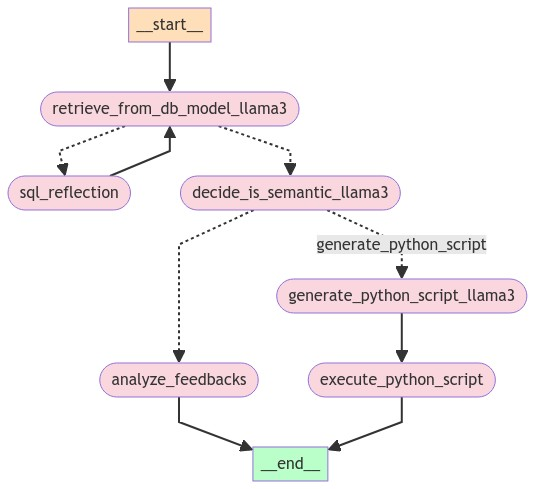

In [11]:
def should_continue(state: AgentState):
    if len(state["messages"]) > iterations * 2:
        return "decide_is_semantic_llama3"
    return "sql_reflection"


workflow_llama3 = StateGraph(AgentState)

workflow_llama3.add_node("retrieve_from_db_model_llama3", retrieve_from_db_model_llama3)
workflow_llama3.add_node("sql_reflection", sql_reflection_node)
workflow_llama3.add_node("decide_is_semantic_llama3", decide_is_semantic_llama3)
workflow_llama3.add_node("generate_python_script_llama3", generate_python_script_llama3)
workflow_llama3.add_node("execute_python_script", execute_python_script)
workflow_llama3.add_node("analyze_feedbacks", analyze_feedbacks)

workflow_llama3.set_entry_point("retrieve_from_db_model_llama3")
workflow_llama3.add_conditional_edges(
    "retrieve_from_db_model_llama3",
    should_continue,
    {
        "decide_is_semantic_llama3": "decide_is_semantic_llama3",
        "sql_reflection": "sql_reflection"
    }
)
workflow_llama3.add_edge("sql_reflection", "retrieve_from_db_model_llama3")
workflow_llama3.add_conditional_edges(
    "decide_is_semantic_llama3",
    is_semantic,
    {
        "analyze_feedbacks": "analyze_feedbacks",
        "generate_python_script": "generate_python_script_llama3",
    },
)
workflow_llama3.add_edge("generate_python_script_llama3", "execute_python_script")
workflow_llama3.add_edge("execute_python_script", END)
workflow_llama3.add_edge("analyze_feedbacks", END)

app_llama3 = workflow_llama3.compile()
print("llama3 Agent :- ")
display(Image(app_llama3.get_graph().draw_mermaid_png()))

-------------------------------------------------------
-----------------retrieve_from_db-----------------
input_question :- Graph the total number of orders of each customer. X axis of the graph has to be in ascending order.
output_query :- SELECT customer_id, COUNT(*) AS count FROM orders GROUP BY customer_id ORDER BY customer_id ASC
--------------------------------------------------
-----------------sql_reflection_node-----------------
reflection :- 
**Query Critique and Recommendations**

The provided SQL query is:
```sql
SELECT customer_id, COUNT(*) AS count
FROM orders
GROUP BY customer_id
ORDER BY customer_id ASC;
```
**Good:**

* The query is simple and easy to understand.
* It correctly groups the orders by customer_id and counts the number of orders for each customer.
* The ORDER BY clause ensures that the results are sorted in ascending order by customer_id.

**Suggestions for Improvement:**

1. **Consider adding a filter for active customers**: If you only want to include c

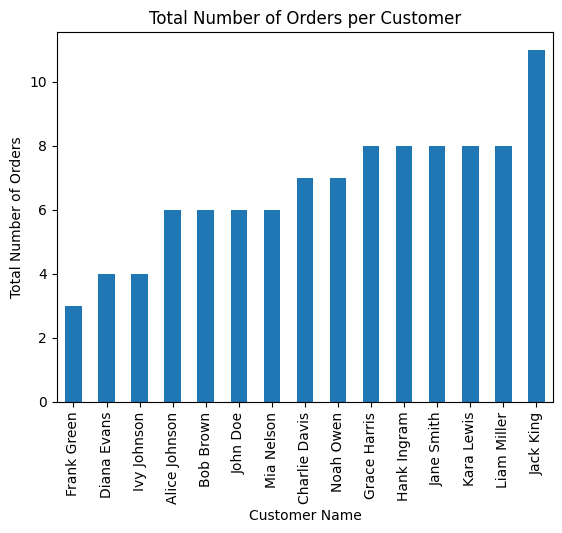

{
  "status": "success",
  "stdout": "",
  "stderr": ""
}


In [12]:
print("-------------------------------------------------------")
output_llama3 = app_llama3.invoke({"messages": [("human", "Graph the total number of orders of each customer. X axis of the graph has to be in ascending order.")]})
print(output_llama3["messages"][-1].content)